In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import json
import datetime
from datetime import datetime as dt
from bokeh.charts import Donut, show
from bokeh.io import output_notebook, push_notebook, show

output_notebook()
color = sns.color_palette()

%matplotlib inline
print "Packages Loaded Successfully"

Loading BokehJS ...

Packages Loaded Successfully


### Input pre-processed data

In [2]:
All_df = pd.read_csv('data/cleaned.csv')
print("Number of all_df rows: {:.0f}".format(All_df.shape[0]))

count_df = pd.read_csv('result/Output1.csv')
print "\n"
print("Number of count_df rows: {:.0f}".format(All_df.shape[0]))

## Convert string timestamp to pd.timestamp
All_df['time'] = pd.to_datetime(All_df['time'])

Number of all_df rows: 435816


Number of count_df rows: 435816


## Output 2: Visualize the number of emails sent over time by some of the most prolific senders

* Visualize Cumulative email sent over time
* Visualize emails sent in time bucket
* Visualize weekday distribution

### Choose top 5 person for visualization

In [3]:

## exclude the unknown sender
count_df = count_df.loc[count_df['person'] != 'unknown']
top_number = 5
temp_df = count_df.iloc[:top_number]

## Name List of top 20 prolific sender
top_list = temp_df.person.unique()

In [4]:
## Top 5 sender's records df

top_df = All_df.loc[All_df['sender'].isin(top_list)].copy()

### Day of Week

In [5]:
top_df['weekday'] = top_df['time'].apply(lambda x:x.dayofweek)

### Cumulative Email Sent over Time

In [6]:
## Extract Year-Month-Day only
top_df['day'] = pd.to_datetime(top_df.time.map(lambda x: x.strftime('%Y-%m-%d')))

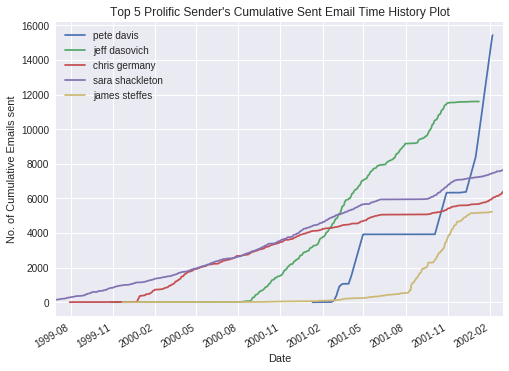

In [7]:

## Calculate cumulative email sent over time
def cum_count(grp):
    grp['cum_count'] = grp['daily_count'].cumsum()
    return grp


cum_df = pd.DataFrame(top_df.groupby(['sender','day']).count()['time'])
cum_df.columns=['daily_count']
cum_df = cum_df.groupby('sender').apply(cum_count)

plt.figure(figsize=(8,6))

## plot cumulative email sent over time
for name in top_list:
    cum_df.loc[name].cum_count.plot()
    
plt.legend(top_list.tolist())
plt.xlabel('Date')
plt.ylabel('No. of Cumulative Emails sent')
plt.title("Top 5 Prolific Sender's Cumulative Sent Email Time History Plot")

## Save it as png for second output result
plt.xlim([datetime.date(1999, 7, 1), datetime.date(2002, 3, 1)])
plt.savefig('result/output2.png')
plt.show()


* Generally, top 5 senders sent emails with constant rate.
* However, 3 of 5 stopped sending email during 2001-04-2001-10. 2 of 5 accelerated sending emails.

### Visualize Email Sents in Time Bucket

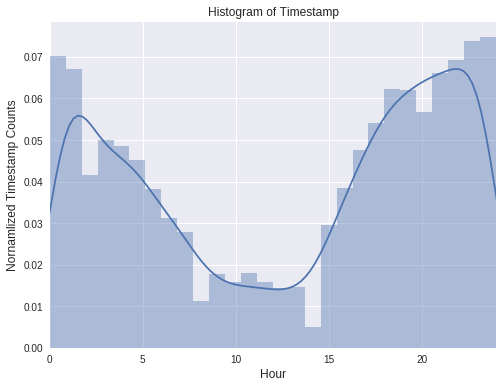

In [8]:
top_df['hour'] = top_df['time'].apply(lambda x:x.hour+x.minute/60.0 )

## Timestamp Distribution
## Plot the histogram of Timestamp

plt.figure(figsize=(8,6))
sns.distplot(top_df['hour'].values, kde=True)
plt.title('Histogram of Timestamp')
plt.xlabel('Hour', fontsize=12)
plt.ylabel('Nornamlized Timestamp Counts', fontsize=12)
axes = plt.gca()
axes.set_xlim([0,24])
#axes.set_ylim([ymin,ymax])

plt.show()

* Most emails sent before 8am and after 15pm

### Plot the Timestamp Distribution in Time Bucket

In [9]:
## Hash the timestamp into 8-hours time bucket
def eight_hour_hash(i):
    if i<8:
        return 0
    elif i<16:
        return 1
    else:
        return 2
    
top_df['8h_hash'] = top_df['hour'].apply(lambda x:eight_hour_hash(x))
temp_df =  pd.concat([top_df,pd.get_dummies(top_df['8h_hash'], prefix="8hour_bucket").astype(np.int8)],axis = 1)


In [10]:
## Donut Plot Visualization of timestamp distribution in time bucket

temp_list = []
for i in range(3):
    temp_list.append('8hour_bucket_'+str(i))

temp1_df = pd.melt(temp_df, id_vars=['sender'],
             value_vars=temp_list,
             value_name='sent_count', var_name='sent_timebucket')

temp1_df.replace(to_replace = {'sent_timebucket':{'8hour_bucket_0':'1st 8hr-bucket',
                                       '8hour_bucket_1':'2nd 8hr-bucket',
                                       '8hour_bucket_2':'3th 8hr-bucket'}}, inplace = True)

d = Donut(temp1_df, label=['sender', 'sent_timebucket'], values='sent_count',
          text_font_size='10pt', hover_text='sent_count',title = 'Proportion of Emails Sent in Each 8hr-bucket')

show(d)

/home/dawei/anaconda2/lib/python2.7/site-packages/bokeh/charts/utils.py:464: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  df.sortlevel(inplace=True)


* Most emails sent in 1st/3th 8hr-bucket for 4 of top 5 senders

### Visualize weekday distribution

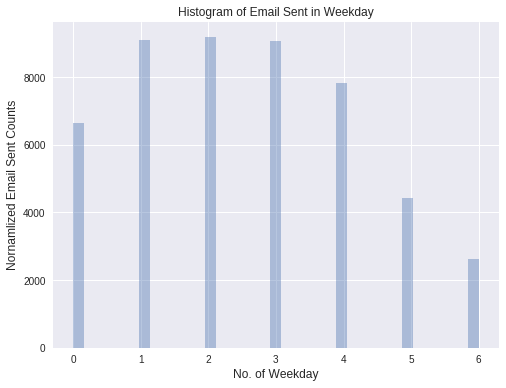

In [11]:
## Plot the histogram of weekday

plt.figure(figsize=(8,6))
sns.distplot(top_df['weekday'].values, kde=False)
plt.title('Histogram of Email Sent in Weekday')
plt.xlabel('No. of Weekday', fontsize=12)
plt.ylabel('Nornamlized Email Sent Counts', fontsize=12)
axes = plt.gca()

#axes.set_ylim([ymin,ymax])

plt.show()

* Top 5 senders sent more emails in Tu/Wed/Th
* They sent emails during weekend as well

## Output2 Summary

* Generally, top 5 senders sent emails with constant rate.
* However, 3 of 5 stopped sending email during 2001-04 to 2001-10. 2 of 5 accelerated sending emails.
* Probably, the dataset don't have the full records during 2001-14 to 2001-10 for those people.
* Probably, Something(Enron Scandal) happened that they cannot send emails during 2001-04 to 2001-10.
* Most of emails sent from top 5 prolific senders are sent befrom 8am and after 15pm.
* Top 5 senders sent more emails in Tu/Wed/Th

## Output 3: Visualize the number of unique people/email addresses who contacted them over the same time period



In [12]:

## Recipients are people in top_list now
top_df = All_df.loc[All_df['recipients'].isin(top_list)].copy()
top_df['day'] = pd.to_datetime(top_df.time.map(lambda x: x.strftime('%Y-%m-%d')))

In [13]:
## Calculate cumulative number of unique people/email contact them

def forwardfill(grp):
    grp['unique_sender'] = grp['unique_sender'].ffill()
    return grp

temp_df = top_df[['sender','recipients']]
unique_count = temp_df.drop_duplicates().groupby('recipients').cumcount() + 1
unique_count = unique_count.reindex(top_df.index)

top_df['unique_sender'] = unique_count
top_df = top_df.groupby('recipients').apply(forwardfill)

In [14]:
cum_df = pd.DataFrame(top_df.groupby(['recipients','day']).unique_sender.max())

### Plot the Absolute Cumulative Unique People/Email Contact Them

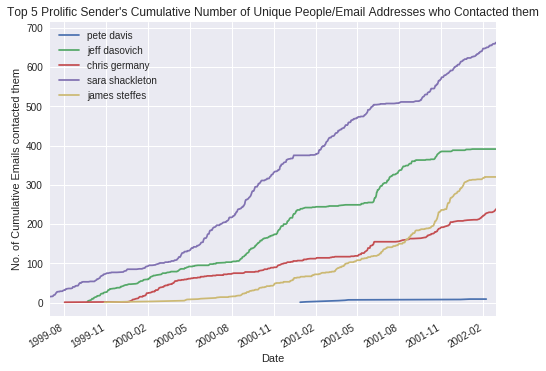

In [15]:
plt.figure(figsize=(8,6))

for name in top_list:
    cum_df.loc[name].unique_sender.plot()
plt.legend(top_list.tolist())
plt.xlabel('Date')
plt.ylabel('No. of Cumulative Emails contacted them')
plt.title("Top 5 Prolific Sender's Cumulative Number of Unique People/Email Addresses who Contacted them")

plt.xlim([datetime.date(1999, 7, 1), datetime.date(2002, 3, 1)])
plt.show()

### Plotthe Absolute Cumulative Unique People/Email Contact Them
* Normalized by Sara Shackleton's data

In [16]:
## Initial df
start = datetime.datetime(1999,7,1)
end = datetime.datetime(2002, 3, 1)

delta = end-start
day_list=[]
for i in range(delta.days + 1):
    day_list.append(start + datetime.timedelta(days=i))
    
iterables = [top_list.tolist(), day_list]
relative_cum_df = pd.DataFrame(index = pd.MultiIndex.from_product(iterables, names=['recipients', 'day']))
relative_cum_df = relative_cum_df.join(cum_df).groupby('recipients').apply(forwardfill).fillna(0)


In [17]:
def normalization(grp):
    grp['normalized'] = grp['unique_sender'] / relative_cum_df.loc['sara shackleton']['unique_sender'].values
    #grp['normalized'] = -ralative_cum_df.loc['sara shackleton']['unique_sender'].values + grp['unique_sender'] 

    return grp

relative_cum_df = relative_cum_df.groupby('recipients').apply(normalization)

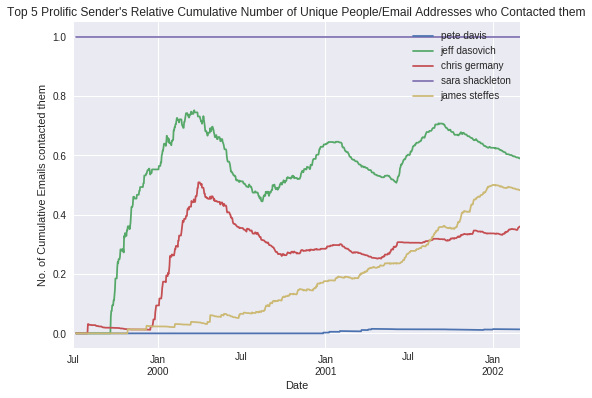

In [18]:
plt.figure(figsize=(8,6))

for name in top_list:
    relative_cum_df.loc[name]['normalized'].plot()
plt.legend(top_list.tolist(),loc=1)
plt.xlabel('Date')
plt.ylabel('No. of Cumulative Emails contacted them')
plt.title("Top 5 Prolific Sender's Relative Cumulative Number of Unique People/Email Addresses who Contacted them")

plt.xlim([datetime.date(1999, 7, 1), datetime.date(2002, 3, 1)])
plt.show()

## Output3 Summary

* Suprisingly, Pete Davis only receive 9 emails during the same time periods
* Sara Shackleton receive most emails 
* Relative numbers for Jeff and Chirs decreases during 2000-05 to 2001-07